# Assignment: Linear Models
## Do three questions.
### `! git clone https://github.com/ds4e/linearModels`

**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?
2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)
3. Can linear regression be used for classification? Explain why, or why not.
4. What are signs that your linear model is over-fitting?
5. Clearly explain multi-colinearity using the two-stage least squares technique.
6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?
7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

1. A model is linear when its prediction is a linear combination of the parameters.
2. The coefficient represents the difference in the predicted outcome between the group and the baseline group, holding all other variables constant. The interecept in this case captures the mean outcome for the baseline group.
3. Linear regression can be used for classification with pitfalls. Logistic regression is generally preferred because it models the probability directly and contrains predictions between 0 and 1.
4. Over-fitting happens when the model is too closely tailored to the training data and fails to generalize to new data. Signs include extremely low error on training data but significantly higher error on test data, high variance in model predictions when using different training sets, and a model with an excessive number of predictors.
5. Multi-collinearity refers to a situation where two or more precictors are highly correlated. Using the two-stage least-squares technique, the first stage regresses an endogenous variable on a set of instruments. If the instruments are highly collinear, the first stage will have trouble isolating the exogenous variation in the endogenous variable. This leads to unstable or imprecise predicted values used in the second stage, inflating the standard errors of the final estimates.
6. Including polynomial terms or other transformations as predictors as well as adding interaction terms between predictors if the effect of one variable depends on the level of another.
7. The intercept if the precicted value of the outcome y when all predictors are set to zero. The slope coefficient represents the expected change in y for a one-unit increase in that predictor, holding all other variables constant. The coefficient for a dummy variable indicates the difference in the predicted outcome between the group where the dummy equals 1 and the baseline group.

**Q2.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.
2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?
3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?
4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.
7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df = pd.read_csv('https://raw.githubusercontent.com/Lisabyy/linearModels/refs/heads/main/data/Q1_clean.csv') # Load the data
df.rename(columns={"Review Scores Rating": "Review_Scores_Rating",
                   "Neighbourhood ": "Neighborhood", "Property Type": "Property_Type"}, inplace=True)
df.head() # Glance at the data

,Price,Review_Scores_Rating,Neighborhood,Property_Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt



Average Price by Neighborhood:
 Neighborhood
Manhattan        183.664286
Staten Island    146.166667
Brooklyn         127.747378
Queens            96.857233
Bronx             75.276498
Name: Price, dtype: float64

Average Review Score by Neighborhood:
 Neighborhood
Brooklyn         92.363497
Manhattan        91.801496
Bronx            91.654378
Queens           91.549057
Staten Island    90.843750
Name: Review_Scores_Rating, dtype: float64

Most expensive neighborhood on average: Manhattan


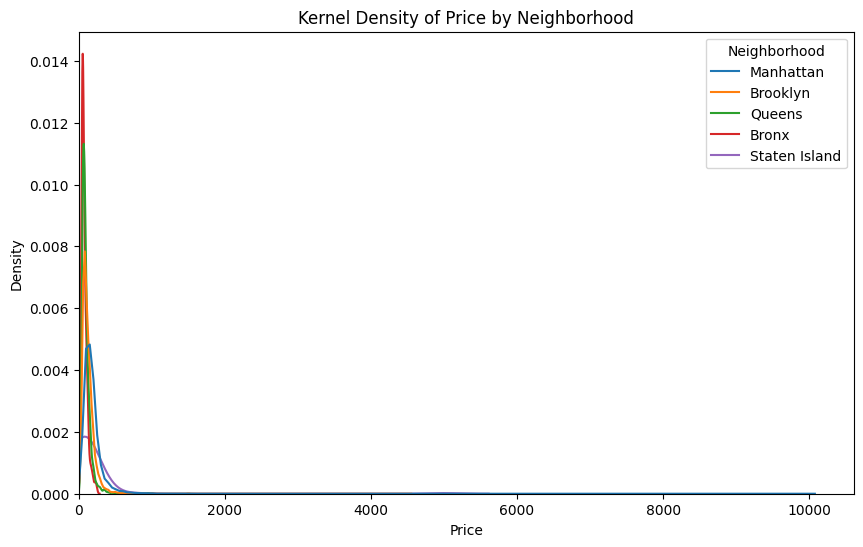

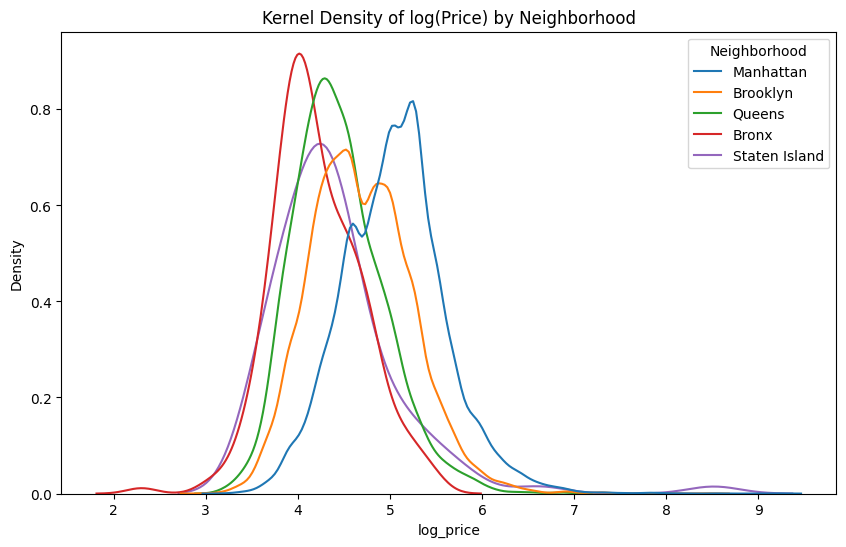

In [7]:
# 1a. Average price and average score by neighborhood
avg_price_by_nb = df.groupby("Neighborhood")["Price"].mean().sort_values(ascending=False)
avg_score_by_nb = df.groupby("Neighborhood")["Review_Scores_Rating"].mean().sort_values(ascending=False)

print("\nAverage Price by Neighborhood:\n", avg_price_by_nb)
print("\nAverage Review Score by Neighborhood:\n", avg_score_by_nb)

# Identify which borough is the most expensive on average
most_expensive_borough = avg_price_by_nb.index[0]
print(f"\nMost expensive neighborhood on average: {most_expensive_borough}")

# 1b. Kernel density plots of Price and log(Price) grouped by Neighborhood
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="Price", hue="Neighborhood", common_norm=False)
plt.title("Kernel Density of Price by Neighborhood")
plt.xlim(0, None)  # to avoid negative axis if there are outliers
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(data=df.assign(log_price=np.log(df["Price"])),
            x="log_price", hue="Neighborhood", common_norm=False)
plt.title("Kernel Density of log(Price) by Neighborhood")
plt.show()

In [9]:
#2
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# OLS regression with no intercept
model_no_int = smf.ols("Price ~ C(Neighborhood) - 1", data=df).fit()
print("\n=== Regression: Price ~ Neighborhood (No Intercept) ===")
print(model_no_int.summary())

# Compare the coefficients to the average prices from part 1
coeffs_no_int = model_no_int.params
print("\nCoefficients (no intercept) vs. average prices:\n")
comparison_no_int = pd.DataFrame({
    "Regression_Coeff": coeffs_no_int,
    "Avg_Price": avg_price_by_nb  # from part 1
})
print(comparison_no_int)


=== Regression: Price ~ Neighborhood (No Intercept) ===
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     268.9
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          4.43e-226
Time:                        19:07:19   Log-Likelihood:            -1.4174e+05
No. Observations:               22153   AIC:                         2.835e+05
Df Residuals:                   22148   BIC:                         2.835e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [10]:
#3
model_int = smf.ols("Price ~ C(Neighborhood)", data=df).fit()
print("\n=== Regression: Price ~ Neighborhood (With Intercept) ===")
print(model_int.summary())

# Interpretation:
#  - The intercept is the mean price for the reference category (alphabetically first by default,
#    or you can set one explicitly).
#  - Each neighborhood's coefficient is the difference in mean price relative to the reference.


=== Regression: Price ~ Neighborhood (With Intercept) ===
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     268.9
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          4.43e-226
Time:                        19:08:31   Log-Likelihood:            -1.4174e+05
No. Observations:               22153   AIC:                         2.835e+05
Df Residuals:                   22148   BIC:                         2.835e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [11]:
#4
# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Fit the model on the training set
model_4 = smf.ols("Price ~ Review_Scores_Rating + C(Neighborhood)", data=train_df).fit()

# Predict on the test set
pred_4 = model_4.predict(test_df)

# Evaluate
mse_4 = mean_squared_error(test_df["Price"], pred_4)
rmse_4 = np.sqrt(mse_4)
r2_4 = r2_score(test_df["Price"], pred_4)

print("\n=== Regression 4: Price ~ Review_Scores_Rating + Neighborhood ===")
print(model_4.summary())
print(f"R^2 on test set:  {r2_4:.4f}")
print(f"RMSE on test set: {rmse_4:.2f}")

# Coefficient on Review_Scores_Rating
coeff_rating_4 = model_4.params["Review_Scores_Rating"]
print(f"Coefficient on Review_Scores_Rating: {coeff_rating_4:.2f}")


=== Regression 4: Price ~ Review_Scores_Rating + Neighborhood ===
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     189.8
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          1.33e-197
Time:                        19:09:03   Log-Likelihood:            -1.1348e+05
No. Observations:               17722   AIC:                         2.270e+05
Df Residuals:                   17716   BIC:                         2.270e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [15]:
#5
# Split again (or reuse the previous split to keep consistency)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

model_5 = smf.ols("Price ~ Review_Scores_Rating + C(Neighborhood) + C(Property_Type)",
                  data=train_df).fit()
pred_5 = model_5.predict(test_df)

mse_5 = mean_squared_error(test_df["Price"], pred_5)
rmse_5 = np.sqrt(mse_5)
r2_5 = r2_score(test_df["Price"], pred_5)

print("\n=== Regression 5: Price ~ Review_Scores_Rating + Neighborhood + Property_Type ===")
print(model_5.summary())
print(f"R^2 on test set:  {r2_5:.4f}")
print(f"RMSE on test set: {rmse_5:.2f}")

coeff_rating_5 = model_5.params["Review_Scores_Rating"]
print(f"Coefficient on Review_Scores_Rating: {coeff_rating_5:.2f}")


=== Regression 5: Price ~ Review_Scores_Rating + Neighborhood + Property_Type ===
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     51.46
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          2.52e-218
Time:                        19:11:03   Log-Likelihood:            -1.1339e+05
No. Observations:               17722   AIC:                         2.268e+05
Df Residuals:                   17699   BIC:                         2.270e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

6. From part 4 to 5, the coefficient on Reivews_Scores_Rating decreases, implying that the addition of Property_type absorbs some variation that was previously attributed to rating or neighborhood.

**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

**Q4.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

**Q5.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q6.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

**Q7.** In class, we showed that for the single linear regression model,
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

1. When will $b^*$ be large or small, depending on the relationship between $X$ and $Y$ and the variance of $X$?
2. Suppose you have measurement error in $X$ which artificially inflates its variance (e.g. bad data cleaning). We'll model this as saying the "real" value of $X$ for observation $i$ is $z_i$, but we observe $x_i = z_i + n_i$, where $n_i$ is the added noise. Does this affect the intercept of the regression? What happens to the $b^*$ coefficient relative to a noise-less model? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
3. Suppose the noise $n_i$ is independent of $z_i$ and $y_i$, so that (approximately)
$$
\dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})(n_i - \bar{n}) =0, \quad \dfrac{1}{N} \sum_{i=1}^N (z_i - \bar{z})(n_i - \bar{n}) =0.
$$
and that the mean of the bias is zero, so that
$$
\dfrac{1}{N} \sum_{i=1}^N n_i = 0.
$$
In this case, the noise $n_i$ is zero on average and independent of the values of $x_i$ and $y_i$: It's just measurement error or lazy data cleaning.
Explain the intuition of your result.

4. How does attenuation factor into the cost-benefit analysis of gathering higher quality data or cleaning it more carefully?

1. b* is proportional to the covariance between X and Y. If X and Y have a strong linear relationship, b* will be larger.
2. When the measures X includes random noise, the slope estimate typically understates the true relationship. Intuitively, ading noise to X inflates the variance of X, which pushes the estimated slope toward zero.
3. If the noise in the outcome has zero mena and is independent, the OLS estimator remains unbiased. The slope might have higher variance, but on average it will be correct if the classical assumptions hold.
4. Reducing measurement error can be expensive or time-consuming. However, if the measurement error in
X is severe, the slope estimate will be significantly biased toward zero (attenuation). One must weigh the cost of collecting more accurate
X data against the benefit of a less biased estimate of b*.

**Q8.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?

**Q9.** There is a folder called `heart_failure` which contains reasonably detailed health data on patients and whether they die of congestive heart failure.

1. Load the data and perform an 80/20-train/test split.
2. Using dummy/one-hot-encoded variables and transformations of the numeric features, build the best model you can. **But**, do not delete code chunks or revise your work substantially as you experiment. Just keep moving forward with your ideas and experiments.
3. When you're done, scroll through your notebook. What worked and what didn't? Does your code have intention, or are you randomly experimenting? If you had to do this again, what might you do differently to get to a good model faster?


**Q10.** Let's look at a cousin of Linear Regression, called **kernel regression** or **local constant least squares** or **Nadaraya-Watson Estimator**.

We derived the OLS estimator for single linear regression by minimizing
$$
SSE(b_0, b_1) = \frac{1}{N}\sum_{i=1}^N (y_i - b_0 - b_1 x_i)^2
$$
with solution
$$
\hat{b}_0 = \bar{y} - \hat{b}_1 \bar{x}, \quad \hat{b}_1 = \dfrac{\frac{1}{N} \sum_{i=1}^N (x_i-\bar{x})(y_i - \bar{y})}{s_x^2}.
$$

When you step back and think about it, this is a bit weird: The algorithm is computing sample means, variances, and covariances, and using those to create a predictive model. The data themselves arguably vanish from the solution. This is elegant, this is strange.

Instead, let $k(z)$ be a kernel function, such as the Gaussian
$$
k(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}
$$
or uniform
$$
k(z) = \begin{cases}
1/2, & |z| \le \frac{1}{2}\\
0, & \text{otherwise.}
\end{cases}
$$
We'll instead minimize, or each predictor value $x$,
$$
SSE(\hat{y}(x)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(x)\right\rbrace^2 \dfrac{1}{h} k \left( \dfrac{x-x_i}{h} \right).
$$

1. Show that the optimal predictor is
$$
\hat{y}(x) = \dfrac{ \frac{1}{Nh} \sum_{i=1}^N  y_i k \left( \dfrac{x-x_i}{h} \right) }{\frac{1}{Nh} \sum_{i=1}^N k \left(  \dfrac{x-x_i}{h} \right)}
$$
This has many names, but let's call it the local constant least squares (LCLS) estimator, as opposed to ordinary least squares (OLS).

2. Compare and contrast LCLS with both OLS and $k$-Nearest Neighbor as a regression algorithm.

3. Write a function or class that implements the LCLS estimator for a single predictor variable $x$. For a default bandwidth $h$, you can use the maximum of the Silverman plug-ins for estimating kernel densities for $X$ and $Y$:
$$
h_y = 1.06 \times s_y^{-1/5}, \quad h_x = 1.06 \times s_x^{-1/5},
$$
$$
h = \max \{ h_y, h_x \}.
$$
For the kernel, you can hard-code the uniform, Gaussian, or Epanechnikov, or make it a parameter the user can adjust with a default choice.

4. For one of the datasets available for the homework, use your LCLS estimator from part 3 to predict values $\hat{y}(x_i)$ for each datapoint $x_i$. Plot your estimator $\hat{y}$ as a line over a scatterplot of the data $\{(x_i,y_i)\}_{i=1}^N$. Tune the bandwidth until you

5. Conceptually, how would you extend this analysis to a vector of predictors, $x = (x_1, ..., x_L)$ instead of just one explanatory variable $x$?
